Train a GPR model with "Coulombmatrix eigenvalue featurization" and check performance by r2_score, MSE, MAE

In [1]:
# Train a GPR model with RDkit featurization
import deepchem as dc
import pandas as pd
import numpy as np
import rdkit
import sklearn

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [18]:
#load the dataset (polymer smiles and their ioization energy)
print("loading the data...")
loader = dc.data.CSVLoader(["Ei"], feature_field="smiles",featurizer=dc.feat.CoulombMatrixEig(max_atoms=22))
Data = loader.create_dataset('../csv_files/Polymers_Ei.csv')

loading the data...


[15:41:13] UFFTYPER: Unrecognized atom type: *_ (0)
[15:41:13] UFFTYPER: Unrecognized atom type: *_ (1)
c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\feat\molecule_featurizers\coulomb_matrices.py:151: RuntimeWarning: divide by zero encountered in divide
  m = np.outer(z, z) / d
c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\feat\molecule_featurizers\coulomb_matrices.py:151: RuntimeWarning: invalid value encountered in divide
  m = np.outer(z, z) / d
[15:41:13] UFFTYPER: Unrecognized atom type: *_ (0)
[15:41:13] UFFTYPER: Unrecognized atom type: *_ (1)
[15:41:13] UFFTYPER: Unrecognized atom type: *_ (0)
[15:41:13] UFFTYPER: Unrecognized atom type: *_ (5)
[15:41:13] UFFTYPER: Unrecognized atom type: *_ (0)
[15:41:13] UFFTYPER: Unrecognized atom type: *_ (6)
[15:41:13] UFFTYPER: Unrecognized atom type: *_ (0)
[15:41:13] UFFTYPER: Unrecognized atom type: *_ (2)
[15:41:13] UFFTYPER: Unrecognized atom type: *_ (0)
[15:41:

In [19]:
Data.X[1]

array([107.57389054,  40.77235128,  23.62417288,   0.35613457,
         0.21504317,   0.20771771,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

In [20]:
Data.ids[1]

'[*]CC([*])F'

#since the featurizer has difficulties with reading the raw smiles trings, we first convert these to rdkit objects.
Data = pd.read_csv('../csv_reader/Datafile2.csv', usecols=["smiles","Ei"])
from rdkit import Chem

TempData = Data.values.tolist() #change the dataframe to a loopable list
RdkitObj = []

for molecule in TempData:
    mol = Chem.MolFromSmiles(molecule[0])
    RdkitObj.append(mol) #add all the converted smiles trings to the array

#now featurize the rdkitobj with the coulombmatrixEig featurizer.
featurizer = dc.feat.CoulombMatrixEig(max_atoms=23)
FeaturizedX = featurizer.featurize(RdkitObj)
#make the dc dataset

Dataset = dc.data.DiskDataset.from_numpy(X=FeaturizedX, y=Data.Ei, ids=Data.smiles, tasks = ["EgC"])
Dataset.X[0]



In [21]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(Data)
print("Data is splitted into: train, valid, test")

Data is splitted into: train, valid, test


In [22]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
model = dc.models.SklearnModel(GaussianProcessRegressor( n_restarts_optimizer=2))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")


fitting model...
model is fitted


In [23]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
print('Test set score:', model.evaluate(test_dataset, metric))

Training set score: {'pearson_r2_score': 1.0}
Test set score: {'pearson_r2_score': 0.00232085260726902}


In [24]:
#calculate MSE score
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
print('Training set score:', model.evaluate(train_dataset, metric))
print('Test set score:', model.evaluate(test_dataset, metric))

Training set score: {'mean_squared_error': 4.3066903281629647e-19}
Test set score: {'mean_squared_error': 41.653095673012736}


In [25]:
#calculate MAE score
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
print('Training set score:', model.evaluate(train_dataset, metric))
print('Test set score:', model.evaluate(test_dataset, metric))

Training set score: {'mean_absolute_error': 6.48277827933469e-10}
Test set score: {'mean_absolute_error': 6.350248401346072}


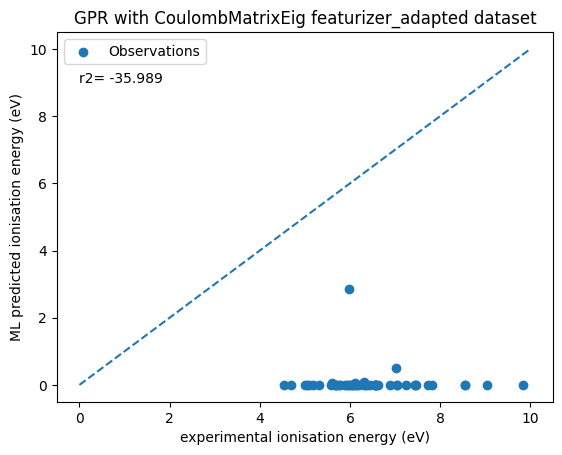

In [30]:
#plot the data
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

#predict the r2_score and convert to string
predicted = model.predict(test_dataset)
score =r2_score(test_dataset.y, predicted)
text = "r2= "+ str(round(score,3))

x=[0,10]
y=[0,10]
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label="Observations")
plt.legend()
plt.xlabel("experimental ionisation energy (eV)")
plt.ylabel("ML predicted ionisation energy (eV)")
plt.title("GPR with CoulombMatrixEig featurizer_adapted dataset")
plt.text(0,9,text)
plt.show()